In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from sklearn.multioutput import MultiOutputRegressor

import math
import pandas as pd
import operator

from scipy import stats
import random
import copy

from scipy.stats import norm, kurtosis


from tqdm import tqdm

In [3]:
import tensorflow as tf
tf.executing_eagerly()
import keras
import keras.backend as K
from keras import layers, models, optimizers, initializers, regularizers, constraints, losses
from keras.models import Sequential, Model, load_model, Input
from keras.layers import (Dense, Concatenate, BatchNormalization, Activation, Add,
                          concatenate, Dropout, AlphaDropout, Reshape, Layer, Multiply, Lambda)
from keras.layers import (Dense, Concatenate, BatchNormalization, Activation, Add,
                          concatenate, Dropout, AlphaDropout, Reshape, Layer, Multiply)
from keras.layers import (Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, 
                          GlobalMaxPooling1D, SeparableConv1D, MaxPool1D, AveragePooling1D, 
                          SeparableConv1D, AtrousConvolution1D)
from keras.layers import (Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, 
                          GlobalMaxPooling2D, SeparableConv2D, MaxPool2D, AveragePooling2D, 
                          SeparableConv2D, AtrousConvolution2D)
from keras.layers import LSTM, GRU, Bidirectional
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.losses import binary_crossentropy,  kullback_leibler_divergence, mean_squared_error

def mish(x):
    return x*K.tanh(K.softplus(x))

def decay(epoch, steps=100):
    initial_lrate = 1e-3
    drop = 0.9
    epochs_drop = 25
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    lrate = max(lrate, 5e-5)
    return lrate

es = EarlyStopping(patience=25, restore_best_weights=True, monitor='val_total_loss')
lrs = LearningRateScheduler(decay, verbose=2)

Using TensorFlow backend.


In [4]:
def grap_year(x):
    y, _, _ = x.split('-')
    return int(y)

def grap_date(x):
    y = x[5:10].replace('-','')
    return y

def grap_hour(x):
    return x[11:13]

# def custom_loss(y_true, y_pred):
#     res = 0
#     cnt = 0
#     for i in range(0, len(y_true), 24):
#         yt = y_true[i:i+24]
#         yp = y_pred[i:i+24]
#         a = np.abs(yt-yp)
#         c = 113
#         S = np.sum(yt)
#         res += np.sum(a*yt/(S*c))
#         cnt += 1
#     return res/cnt

def custom_loss(y_true, y_pred):
    res = np.abs(y_true-y_pred)*y_true
    ans = []
    for i, s in enumerate(res):
        ans.append(s/np.sum(y_true[i]))
    return np.mean(ans)

def custom_loss_nn(y_true, y_pred):
    res = K.abs(y_true*113-y_pred*113)*y_true/K.sum(y_true)
    res = K.mean(res, axis=1)

    return K.mean(res)

class Lookahead(keras.optimizers.Optimizer):
    """The lookahead mechanism for optimizers.
    Default parameters follow those provided in the original paper.
    # Arguments
        optimizer: An existed optimizer.
        sync_period: int > 0. The synchronization period.
        slow_step: float, 0 < alpha < 1. The step size of slow weights.
    # References
        - [Lookahead Optimizer: k steps forward, 1 step back]
          (https://arxiv.org/pdf/1907.08610v1.pdf)
    """

    def __init__(self, optimizer, sync_period=5, slow_step=0.5, **kwargs):
        super(Lookahead, self).__init__(**kwargs)
        self.optimizer = keras.optimizers.get(optimizer)
        with K.name_scope(self.__class__.__name__):
            self.sync_period = K.variable(sync_period, dtype='int64', name='sync_period')
            self.slow_step = K.variable(slow_step, name='slow_step')

    @property
    def lr(self):
        return self.optimizer.lr

    @lr.setter
    def lr(self, lr):
        self.optimizer.lr = lr

    @property
    def learning_rate(self):
        return self.optimizer.learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        self.optimizer.learning_rate = learning_rate

    @property
    def iterations(self):
        return self.optimizer.iterations

    def get_updates(self, loss, params):
        sync_cond = K.equal((self.iterations + 1) // self.sync_period * self.sync_period, (self.iterations + 1))
        slow_params = {p.name: K.variable(K.get_value(p), name='sp_{}'.format(i)) for i, p in enumerate(params)}
        update_names = ['update', 'update_add', 'update_sub']
        original_updates = [getattr(K, name) for name in update_names]
        setattr(K, 'update', lambda x, new_x: ('update', x, new_x))
        setattr(K, 'update_add', lambda x, new_x: ('update_add', x, new_x))
        setattr(K, 'update_sub', lambda x, new_x: ('update_sub', x, new_x))
        self.updates = self.optimizer.get_updates(loss, params)
        for name, original_update in zip(update_names, original_updates):
            setattr(K, name, original_update)
        slow_updates = []
        for i, update in enumerate(self.updates):
            if isinstance(update, tuple):
                name, x, new_x, adjusted = update + (update[-1],)
                update_func = getattr(K, name)
                if name == 'update_add':
                    adjusted = x + new_x
                if name == 'update_sub':
                    adjusted = x - new_x
                if x.name not in slow_params:
                    self.updates[i] = update_func(x, new_x)
                else:
                    slow_param = slow_params[x.name]
                    slow_param_t = slow_param + self.slow_step * (adjusted - slow_param)
                    slow_updates.append(K.update(slow_param, K.switch(
                        sync_cond,
                        slow_param_t,
                        slow_param,
                    )))
                    self.updates[i] = K.update(x, K.switch(
                        sync_cond,
                        slow_param_t,
                        adjusted,
                    ))
        slow_params = list(slow_params.values())
        self.updates += slow_updates
        self.weights = self.optimizer.weights + slow_params
        return self.updates

    def get_config(self):
        config = {
            'optimizer': keras.optimizers.serialize(self.optimizer),
            'sync_period': int(K.get_value(self.sync_period)),
            'slow_step': float(K.get_value(self.slow_step)),
        }
        base_config = super(Lookahead, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        optimizer = keras.optimizers.deserialize(config.pop('optimizer'))
        return cls(optimizer, **config)
    
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [5]:
target = pd.read_csv('./data/SolarPV_Elec_Problem.csv', header=None)
data = pd.read_csv('./data/features3.csv')#.iloc[0:-2,:] # 자료가 21시까지
# sub = pd.read_csv('./data/제출양식_복원값.xlsx')

In [6]:
target2 = pd.read_csv('./data/Solar_PV_July.csv', header=None)

In [7]:
target['year'] = target[0].map(grap_year)
target['md'] = target[0].map(grap_date)
target['hour'] = target[0].map(grap_hour)
target = target.drop(0, axis=1)

In [8]:
target2['year'] = target2[0].map(grap_year)
target2['md'] = target2[0].map(grap_date)
target2['hour'] = target2[0].map(grap_hour)
target2 = target2.drop(0, axis=1)

In [9]:
target = target.fillna(-10)
y = target.groupby(['year', 'md', 'hour']).sum()[1].values[:8760]

In [10]:
y2 = target2.groupby(['year', 'md', 'hour']).sum()[1].values
y2 = np.hstack([y2, [0, 0]])

In [11]:
steps = 24
tr_X = []
tr_y = []
val_X = []
val_y = []

y1 = y[:5136]
for i in range(steps, len(y1)+1, 24):
    tr_X.append(y1[i-steps:i])
    tr_y.append(y1[i:i+24])
    
tr_X = tr_X[:-1]
tr_y = tr_y[:-1]
val_X.append(tr_X[-1])
val_y.append(tr_y[-1])
tr_X.pop(-1)
tr_y.pop(-1)
    
    
y1 = y[5160:6576]
for i in range(steps, len(y1)+1, 24):
    tr_X.append(y1[i-steps:i])
    tr_y.append(y1[i:i+24])
    
tr_X = tr_X[:-1]
tr_y = tr_y[:-1]
val_X.append(tr_X[-1])
val_y.append(tr_y[-1])
tr_X.pop(-1)
tr_y.pop(-1)
    
    
y1 = y[6600:8040]
for i in range(steps, len(y1)+1, 24):
    tr_X.append(y1[i-steps:i])
    tr_y.append(y1[i:i+24])
    
tr_X = tr_X[:-1]
tr_y = tr_y[:-1]
val_X.append(tr_X[-1])
val_y.append(tr_y[-1])
tr_X.pop(-1)
tr_y.pop(-1)
    
    
y1 = y[8064:8760]
for i in range(steps, len(y1)+1, 24):
    tr_X.append(y1[i-steps:i])
    tr_y.append(y1[i:i+24])
    
tr_X = tr_X[:-1]
tr_y = tr_y[:-1]

In [12]:
steps = 24
y1 = y2.copy()
for i in range(steps, len(y1)+1, 24):
    tr_X.append(y1[i-steps:i])
    tr_y.append(y1[i:i+24])
    
te_X = tr_X[-1]
tr_X = tr_X[:-1]
tr_y = tr_y[:-1]

val_X.append(tr_X[-1])
val_y.append(tr_y[-1])
tr_X.pop(-1)
tr_y.pop(-1)

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 5.0000e-03, 4.2100e-01, 4.0770e+00, 7.5910e+00,
       6.5240e+00, 1.0965e+01, 1.4411e+01, 1.1109e+01, 1.6948e+01,
       1.5657e+01, 1.0954e+01, 6.0110e+00, 2.5490e+00, 4.6900e-01,
       8.0000e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [13]:
tr_X = np.array(tr_X)
tr_y = np.array(tr_y)
val_X = np.array(val_X)[:-1]
val_y = np.array(val_y)[:-1]

In [14]:
tr_X.shape, tr_y.shape, val_X.shape, val_y.shape

((382, 24), (382, 24), (3, 24), (3, 24))

In [15]:
from keras.layers.merge import _Merge
from functools import partial
from keras.layers import Lambda, Dense, Input, Concatenate, BatchNormalization, Flatten, Embedding, multiply, Add, Activation

class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
def Denseblock(n, activation=mish, bn=False):
    def f(x):
        x = Dense(n)(x)
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        x = Activation(activation)(x)
        return x
    return f

class wGAN():
    def __init__(self, d_dim, latent_dim, cond_dim):
        # data structure
        self.d_dim = d_dim
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        
        self.score = 19999
        self.score_hist = []
        self.vpred = None
        self.test = None
        
        self.convergence = []
        self.gamma=0.7
        
        self.gen_loss = []
        self.critic_loss = []
        
        self.n_critic = 5
        
        self.gen = self.build_generator()
        self.critic = self.build_critic()
        
        self.gen.trainable = False
        
        cond_ = Input(shape=(self.cond_dim, ))
        
        real_ = Input(shape=self.d_dim[1:])
        z_cri = Input(shape=(self.latent_dim, ))
        fake_ = self.gen([z_cri, cond_])
        
        fake = self.critic([fake_, cond_])
        real = self.critic([real_, cond_])
        
        inter_ = RandomWeightedAverage()([real_, fake_])
        inter = self.critic([inter_, cond_])
        
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=inter_)
        partial_gp_loss.__name__ = 'gradient_penalty'
        
        self.critic_model = Model([real_, z_cri, cond_], [real, fake, inter])
        self.critic_model.compile(loss=[self.wasserstein_loss, self.wasserstein_loss, partial_gp_loss],
                                 optimizer=optimizers.RMSprop(2e-4),
                                 loss_weights = [1, 1, 10]) # 10 is good for overall case
        
        self.critic.trainable = False
        self.gen.trainable = True
        
        z = Input(shape=(self.latent_dim, ))
        self.gen_model = Model([z, cond_], self.critic([self.gen([z, cond_]), cond_]))
        self.gen_model.compile(loss=self.wasserstein_loss, optimizer=optimizers.RMSprop(2e-4))
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        gradients = K.gradients(y_pred, averaged_samples)[0]
        gradients_sqr = K.square(gradients)
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        gradient_penalty = K.square(1 - gradient_l2_norm)
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
        
    def build_generator(self):
        inputs = Input(shape = (self.latent_dim, ))
        cond_inputs = Input(shape=(self.cond_dim, ))
        
        x = Concatenate()([inputs, cond_inputs])
        
        x = Denseblock(64)(x)
        x = Denseblock(32)(x)
        outputs = Dense(24)(x)
        
        gen = Model([inputs, cond_inputs], outputs, name='generator')
        
        return gen
    
    def build_critic(self):
        inputs = Input(shape = self.d_dim[1:])
        cond_inputs = Input(shape=(self.cond_dim, ))

        x = Concatenate()([inputs, cond_inputs])
        
        x = Denseblock(64)(x)
        x = Denseblock(32)(x)
        outputs = Dense(1)(x)
        
#         h = Dense(32)(cond_inputs)
        
#         x = multiply([x, h])
#         x = Lambda(lambda x: K.mean(x), (1, ))(x)
        
#         outputs = Add()([outputs, x])
#         outputs = Activation('sigmoid')(outputs)
        
        disc = Model([inputs, cond_inputs], outputs, name='discriminator')
        
        return disc
    
    def train(self, X, c, epochs=100, batch_size=32):
        global vpred
        real_label = np.ones((batch_size, 1)) * -1
        fake_label = np.ones((batch_size, 1))
        inter_label = np.zeros((batch_size, 1))
        
        for e in range(epochs):
            temp_d_loss = []
            for _ in range(self.n_critic):
                idx = np.random.randint(0, self.d_dim[0], batch_size)
                real = X[idx]
                cond = c[idx]
                
                noise = np.random.normal(0, 0.5, (batch_size, self.latent_dim))
                
                d_loss = self.critic_model.train_on_batch([real, noise, cond], [real_label, fake_label, inter_label])
            self.critic_loss.append(np.mean(temp_d_loss))
                
            g_loss = self.gen_model.train_on_batch([noise, cond], real_label)
            self.gen_loss.append(g_loss)
            
            # eval
            z = np.random.normal(0, 0.5, (1, self.latent_dim))
            zs = np.vstack([z]*3)
            pred = self.gen.predict([zs, val_X/113])*113
            test = self.gen.predict([z, te_X/113])*113
            for _ in range(100): 
                z = np.random.normal(0, 0.5, (1, self.latent_dim))
                zs = np.vstack([z]*3)
                pred += self.gen.predict([zs, val_X/113])*113
                test += self.gen.predict([z, te_X/113])*113
            pred /= 101
            test /= 101
            
            score = custom_loss(val_y, np.clip(pred, 0, 113))
            self.score_hist.append(score)
            if score < self.score:
                self.score = score
                print(self.score)
                self.gen.save_weights('test.h5')
                self.vpred = pred.copy()
                self.test = test
                
            if e%20 == 0:
#                 print(e, score)
                plt.plot(val_y.flatten(), label='true')
                plt.plot(np.clip(pred.flatten(), 0, 113), label='pred')
                plt.legend()
                plt.title(f'epochs {e}')
                plt.savefig(f'{e}.png')
                plt.show()

        self.gen.load_weights('test.h5')

In [19]:
te_X= te_X.reshape((1, 24))

In [20]:
d_dim = tr_X.shape
gan = wGAN(d_dim, 8, 24)
gan.gen_model.summary()
gan.critic_model.summary()

2.716039975058357


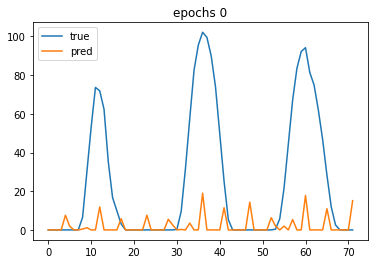

2.7031854499464196
2.6811822954746773
2.677804071121494
2.6407550675055966
2.6343843618365503
2.617258066312434
2.585861572792693
2.583673239798302
2.560904794101821
2.555290864468324
2.5436859266245375
2.5141643300904786
2.49217130747788
2.4819511272405936
2.467199160685004
2.4341508529489246
2.3987818653299016


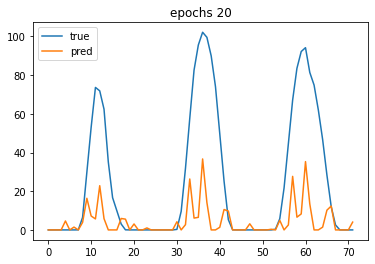

2.3881892707006656
2.3879059746917983
2.376210418993446
2.3437661934614793
2.331691674900134
2.3267275620537706
2.276789546941038
2.260186801670449
2.248291269266794
2.227066971951067
2.223111408368591
2.2082937871676447
2.1716689833975886
2.1506756055155476


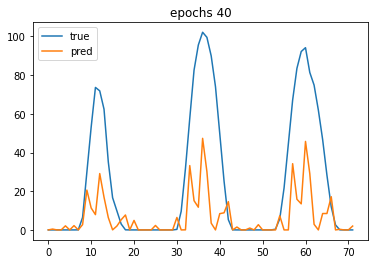

2.1149109049560924
2.096932973135097
2.096417169853009
2.079084995043652
2.071452790503942
2.053379572972875
2.029798932095184
2.0227739683623582
2.0009550430306158
1.9807495527054162
1.9671114440025508
1.945732878487
1.9423672273081583
1.9075096731978287
1.9047159065719268
1.882903224968177
1.8452929935422258


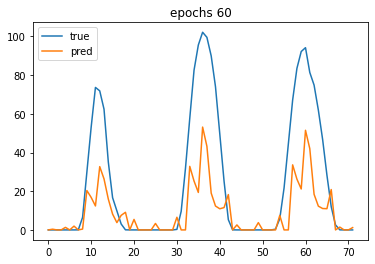

1.8135905612510466
1.8088675480425058
1.8035906619903952
1.7786733935967318
1.7350714094832362
1.7118574917864615
1.6673308374127416
1.6252509166932607
1.613039959310814
1.5939038388018112
1.5730571383859093
1.521523707059843
1.5203095172860814
1.4998598971092356


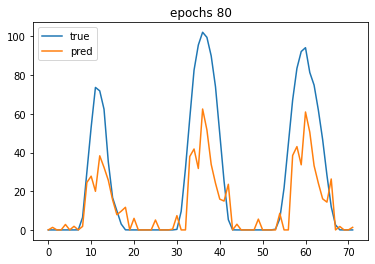

1.446987463167507
1.4258225084335507
1.3825670248142394
1.370688487259465
1.3226245290057426
1.2595783057711618
1.253419687062864
1.1957133339173494
1.157287247593299
1.1177577991852308


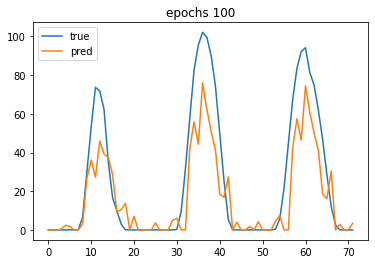

1.1025679318195567
1.0334159927229676
1.0204593378596376
1.009907759992891
0.9581824772978504
0.9574812289640526
0.9391088080621276
0.9110039889886813
0.9040817188729484
0.8343255032737552
0.8326002095243717
0.7951014628277261
0.7847156179668509
0.7524478313894575
0.7216943482525972


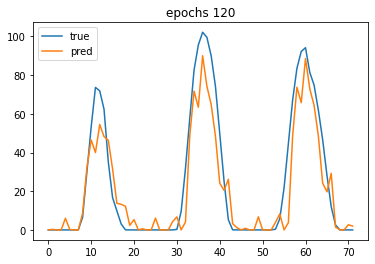

0.7050253010991153
0.6780718111689351
0.6522138097346877
0.6306777425273195
0.6246855104061687
0.6043560107718814
0.590406188245332
0.5435054750239492
0.5205893011006121
0.5183220579361919
0.4783303753997037
0.45298456938684406


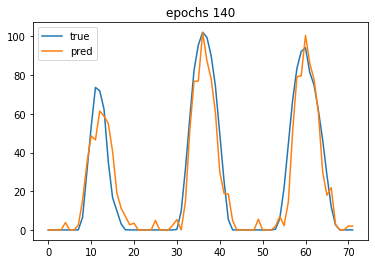

0.44315478093081295
0.43864289066627654
0.4255071614186155
0.40299950005828095
0.3873440264797604
0.3825671208902279
0.36330102468126513
0.3534043813070433


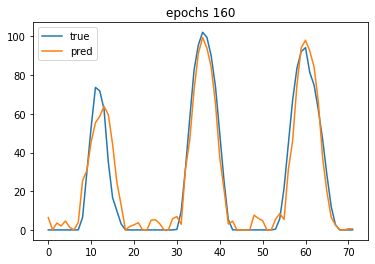

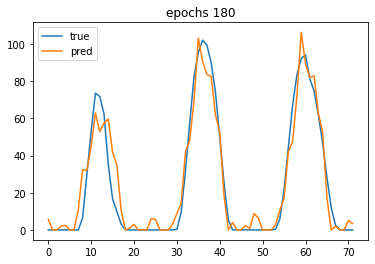

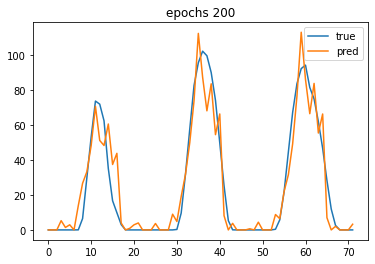

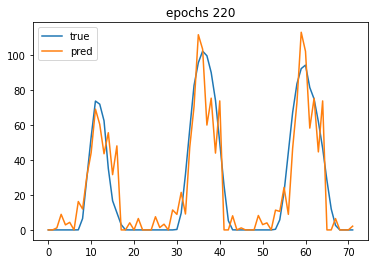

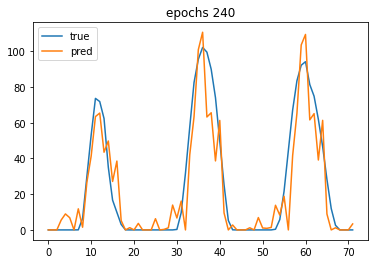

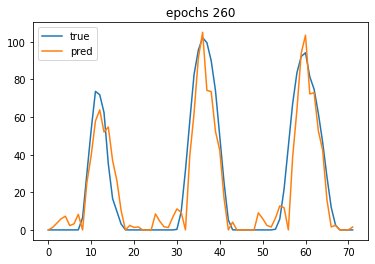

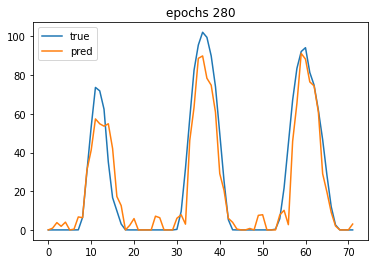

In [21]:
gan.train(tr_y/113, tr_X/113, epochs=300)

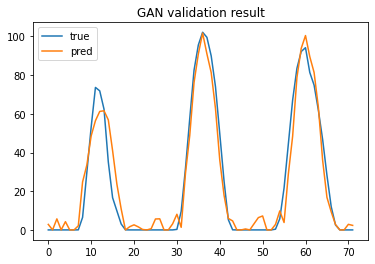

In [22]:
plt.plot(val_y.flatten(), label='true')
plt.plot(np.clip(gan.vpred.flatten(), 0, 113), label='pred')
plt.title('GAN validation result')
plt.legend()
plt.savefig('test.png')
plt.show()